In [1]:
from pathlib import Path
import glob
import exiftool
import soundfile as sf

In [2]:
import numpy as np
import scipy
import pandas as pd
import librosa
import warnings

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors
import datetime as dt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [4]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

In [5]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [6]:
def load_audio_file(audio_file, time_exp_fact, target_samp_rate, scale=False, max_duration=False):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
        #sampling_rate, audio_raw = wavfile.read(audio_file)
        audio_raw, sampling_rate = librosa.load(audio_file, sr=None)

    if len(audio_raw.shape) > 1:
        raise Exception('Currently does not handle stereo files')
    sampling_rate = sampling_rate * time_exp_fact

    # resample - need to do this after correcting for time expansion
    sampling_rate_old = sampling_rate
    sampling_rate = target_samp_rate
    audio_raw = librosa.resample(audio_raw, orig_sr=sampling_rate_old, target_sr=sampling_rate, res_type='polyphase')

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_raw.shape[0])
        audio_raw = audio_raw[:max_duration]
        
    # convert to float32 and scale
    audio_raw = audio_raw.astype(np.float32)
    if scale:
        audio_raw = audio_raw - audio_raw.mean()
        audio_raw = audio_raw / (np.abs(audio_raw).max() + 10e-6)

    return sampling_rate, audio_raw

In [7]:
input_file1 = Path('../../duty-cycle-investigation/data/audiomoth_recordings/recover-20220822/Telephone/20220820_070000.WAV')

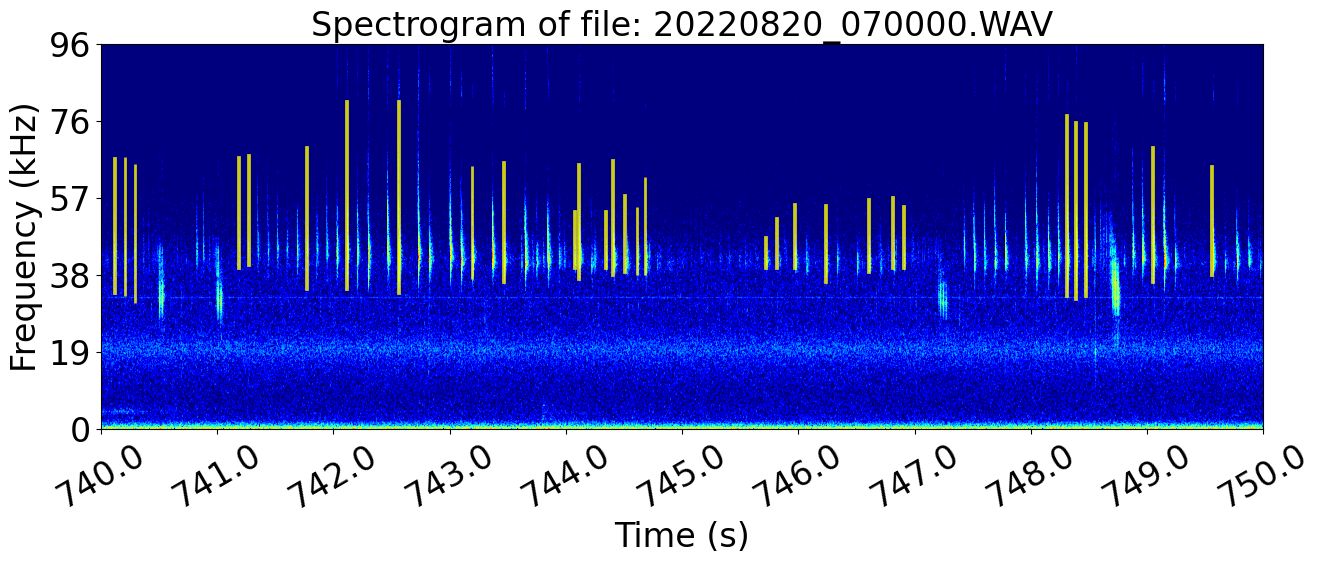

In [8]:
# input_file1 = Path('../../Documents/Research/Lab_related/example/original_recording/recover-20210912_unit2/UBNA_002/20210910_030000.WAV')

cfg = get_config()
cfg['input_audio'] = Path(input_file1)
cfg['tmp_dir'] = Path('../output/tmp')
cfg['output_dir'] = Path('../output_dir/recover-20210912/Foliage/')
cfg['run_model'] = True
cfg['should_csv'] = True
cfg['save'] = True

filename = input_file1.name.split('.')[0]
original_file_dets = pd.read_csv(f'../../duty-cycle-investigation/data/raw/Telephone/bd2__Telephone_{filename}.csv')
audio_data_original = sf.SoundFile(input_file1)
sampling_rate = audio_data_original.samplerate
start = 740
file_duration = 10
audio_data_original.seek(int(sampling_rate*start))
original_audio_seg = audio_data_original.read(int(sampling_rate*file_duration))

vmin = 20*np.log10(np.max(original_audio_seg)) - 50 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(original_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = original_audio_seg
audio_features['sample_rate'] = sampling_rate
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [9]:
section_og_file_dets

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Recover Folder,SD Card,Site name
891,740.1125,740.1181,34062.0,67747.0,Myotis daubentonii,0.380,0.512,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
892,740.2045,740.2103,33203.0,67997.0,Myotis daubentonii,0.383,0.521,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
893,740.2905,740.2956,31484.0,66067.0,Myotis daubentonii,0.441,0.577,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
894,741.1835,741.1884,40078.0,67795.0,Myotis daubentonii,0.396,0.535,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
895,741.2655,741.2710,40937.0,68327.0,Myotis daubentonii,0.383,0.547,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
896,741.7675,741.7728,34921.0,70465.0,Myotis daubentonii,0.382,0.516,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
897,742.1135,742.1206,34921.0,81777.0,Myotis brandtii,0.275,0.510,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
898,742.5555,742.5631,34062.0,81718.0,Myotis daubentonii,0.294,0.502,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
899,743.1895,743.1958,37500.0,65722.0,Pipistrellus nathusii,0.221,0.503,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field
900,743.4605,743.4671,36640.0,66635.0,Myotis daubentonii,0.212,0.511,-1,Echolocation,/mnt/ubna_data_01/recover-20220822/UBNA_001/20...,recover-20220822,UBNA_001,Telephone Field


In [10]:
resampling_rate, audio_data_resampled = load_audio_file(input_file1, 1, 256000)
audio_data_resampled[int(resampling_rate*start):int(resampling_rate*(start+file_duration))]

array([ 0.0022292 ,  0.00193245, -0.00049695, ..., -0.00736735,
       -0.00465178, -0.00139507], dtype=float32)

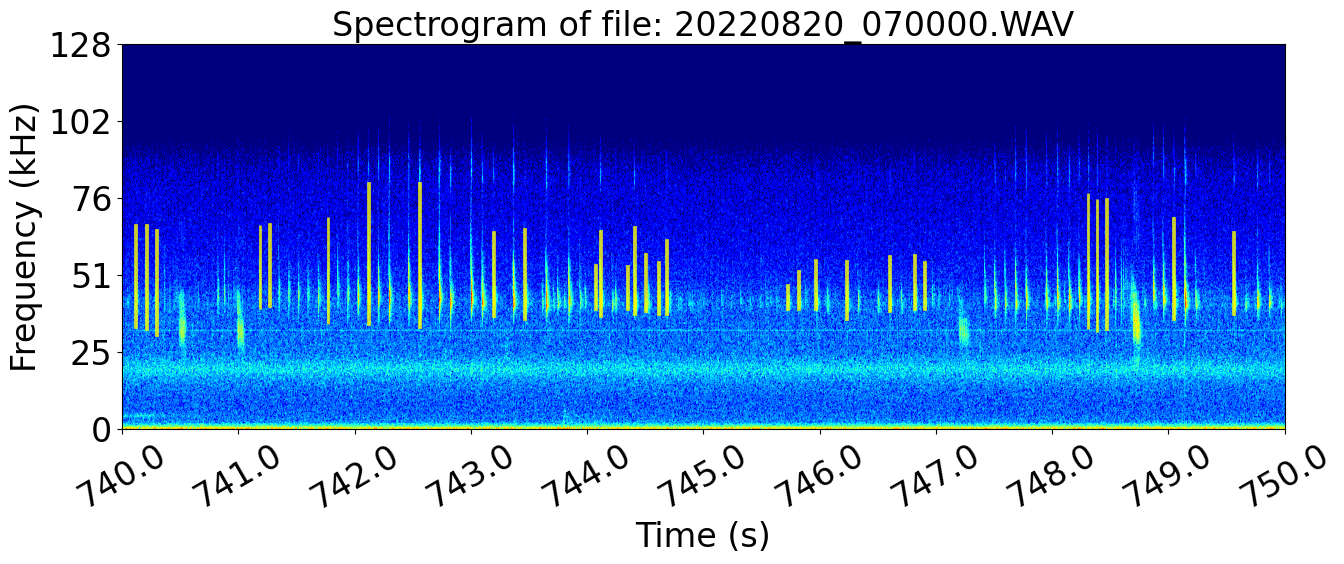

In [11]:
resamp_audio_seg = audio_data_resampled[int(resampling_rate*start):int(resampling_rate*(start+file_duration))]
vmin = 20*np.log10(np.max(resamp_audio_seg)) - 60 # hide anything below -rm_dB dB
vmax = 20*np.log10(np.max(resamp_audio_seg)) + 0 # hide anything below -rm_dB dB

audio_features = dict()
audio_features['file_path'] = input_file1
audio_features['audio_seg'] = resamp_audio_seg
audio_features['sample_rate'] = resampling_rate
audio_features['start'] = start
audio_features['duration'] = file_duration

spec_features = dict()
spec_features['NFFT'] = 1024
spec_features['cmap'] = 'jet'
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax
spec_features['plot_title'] = f"Spectrogram of file: {audio_features['file_path'].name}"

window_cond = np.logical_and(original_file_dets['start_time'] > start, original_file_dets['end_time'] < (start+file_duration))
section_og_file_dets = original_file_dets.loc[window_cond]
plot_dets_over_audio(audio_features, spec_features, section_og_file_dets)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_params = torch.load('../src/models/bat_call_detector/batdetect2/models/Net2DFast_UK_same.pth.tar', map_location=device)
params = net_params['params']
params['device'] = device

In [13]:
model = models.Net2DFast(params['num_filters'], num_classes=len(params['class_names']),
                            emb_dim=params['emb_dim'], ip_height=params['ip_height'],
                            resize_factor=params['resize_factor'])
model.load_state_dict(net_params['state_dict'])
model = model.to(params['device'])
model.eval()

Net2DFast(
  (conv_dn_0): ConvBlockDownCoordF(
    (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_1): ConvBlockDownCoordF(
    (conv): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_2): ConvBlockDownCoordF(
    (conv): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_dn_3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1d): Conv2d(256, 256, kernel_size=(16, 1), stride=(1, 1))
  (conv_1d_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a

In [35]:
args = dict()
args['time_expansion_factor'] = 10.0
args['detection_threshold'] = 0.4
args['chunk_size'] = 3
args['spec_slices'] = False
args['quiet'] = False
args['spec_features'] = False
args['cnn_features'] = True

In [15]:
def run_detector_on_audio_data(model, args, params, audio_full, sampling_rate):
    # store temporary results here
    predictions = []
    spec_feats  = []
    cnn_feats   = []
    spec_slices = []

    # get time expansion  factor
    time_exp = args['time_expansion_factor']

    params['detection_threshold'] = args['detection_threshold']
    top_n=5
    # clipping maximum duration
    duration_full = audio_full.shape[0] / float(sampling_rate)

    return_np_spec = args['spec_features'] or args['spec_slices']

    # loop through larger file and split into chunks
    # TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
    num_chunks = int(np.ceil(duration_full/args['chunk_size']))
    for chunk_id in range(num_chunks):

        # chunk
        chunk_time   = args['chunk_size']*chunk_id
        chunk_length = int(sampling_rate*args['chunk_size'])
        start_sample = chunk_id*chunk_length
        end_sample   = np.minimum((chunk_id+1)*chunk_length, audio_full.shape[0])
        audio = audio_full[start_sample:end_sample]

        # load audio file and compute spectrogram
        duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

        # evaluate model
        with torch.no_grad():
            outputs = model(spec, return_feats=args['cnn_features'])

        # run non-max suppression
        pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
        pred_nms = pred_nms[0]
        pred_nms['start_times'] += chunk_time
        pred_nms['end_times'] += chunk_time

        # if we have a background class
        if pred_nms['class_probs'].shape[0] > len(params['class_names']):
            pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]

        predictions.append(pred_nms)

        # extract features - if there are any calls detected
        if (pred_nms['det_probs'].shape[0] > 0):
            if args['spec_features']:
                spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

            if args['cnn_features']:
                cnn_feats.append(features[0])

            if args['spec_slices']:
                spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

    # convert the predictions into output dictionary
    file_id = input_file1.name
    predictions, spec_feats, cnn_feats, spec_slices =\
                du.merge_results(predictions, spec_feats, cnn_feats, spec_slices)
    results = du.convert_results(file_id, time_exp, duration_full, params,
                                predictions, spec_feats, cnn_feats, spec_slices)

    # summarize results
    if not args['quiet']:
        num_detections = len(results['pred_dict']['annotation'])
        print('{}'.format(num_detections) + ' call(s) detected above the threshold.')

    # print results for top n classes
    if not args['quiet'] and (num_detections > 0):
        class_overall = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
        print('species name'.ljust(30) + 'probablity present')
        for cc in np.argsort(class_overall)[::-1][:top_n]:
            print(params['class_names'][cc].ljust(30) + str(round(class_overall[cc], 3)))

    annotations = results['pred_dict']['annotation']
    out_df = gen_empty_df()
    if annotations:
        out_df = pd.DataFrame.from_records(annotations) 

    return out_df

In [36]:
sampling_rate = audio_data_original.samplerate
out_df_original = run_detector_on_audio_data(model, args, params, original_audio_seg, sampling_rate)

74 call(s) detected above the threshold.
species name                  probablity present
Myotis daubentonii            0.477
Pipistrellus nathusii         0.337
Myotis brandtii               0.139
Myotis bechsteinii            0.016
Barbastellus barbastellus     0.011


In [17]:
# store temporary results here
predictions = []
spec_feats  = []
cnn_feats   = []
spec_slices = []

# get time expansion  factor
time_exp = args['time_expansion_factor']

params['detection_threshold'] = args['detection_threshold']
top_n=5
# clipping maximum duration
duration_full = original_audio_seg.shape[0] / float(sampling_rate)

return_np_spec = args['spec_features'] or args['spec_slices']

# loop through larger file and split into chunks
# TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
num_chunks = int(np.ceil(duration_full/args['chunk_size']))
# for chunk_id in range(num_chunks):
chunk_id = 0

# chunk
chunk_time   = args['chunk_size']*chunk_id
chunk_length = int(sampling_rate*args['chunk_size'])
start_sample = chunk_id*chunk_length
end_sample   = np.minimum((chunk_id+1)*chunk_length, original_audio_seg.shape[0])
audio = original_audio_seg[start_sample:end_sample]

# load audio file and compute spectrogram
duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

In [18]:
spec

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [2.3006, 0.9672, 0.8757,  ..., 0.0000, 0.0000, 0.0000],
          [2.3851, 0.2327, 0.8090,  ..., 0.0000, 0.0000, 0.0000],
          [2.5405, 0.9830, 1.2166,  ..., 0.0000, 0.0000, 0.0000]]]])

In [19]:
spec[0][0].shape

torch.Size([128, 3008])

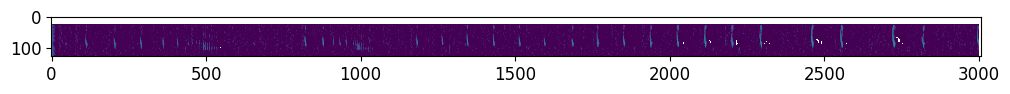

In [20]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(spec[0,0,:,:], norm=colors.LogNorm(vmin=0.1, vmax=1e1))
plt.show()

In [21]:
# evaluate model
with torch.no_grad():
    outputs = model(spec, return_feats=args['cnn_features'])
outputs

{'pred_det': tensor([[[[7.2476e-04, 4.9836e-05, 1.7071e-04,  ..., 9.2074e-05,
            2.6046e-04, 4.8046e-04],
           [1.2972e-03, 6.3662e-06, 8.9383e-06,  ..., 5.4093e-05,
            8.1830e-05, 6.7659e-05],
           [2.0098e-02, 1.9010e-04, 7.0186e-05,  ..., 6.8433e-05,
            4.4618e-05, 5.3962e-05],
           ...,
           [2.2299e-03, 9.8788e-04, 9.9596e-04,  ..., 2.1188e-03,
            2.3398e-03, 4.8961e-03],
           [2.5780e-03, 2.3836e-03, 2.5750e-03,  ..., 1.7572e-03,
            1.8163e-03, 4.5233e-03],
           [1.1844e-03, 8.0571e-04, 1.2547e-03,  ..., 6.5741e-04,
            7.3885e-04, 4.2006e-03]]]]),
 'pred_size': tensor([[[[ 8.8746,  9.5111,  9.0728,  ..., 11.4257, 11.1380, 11.5744],
           [ 9.0828, 12.3346, 12.4660,  ..., 10.7417, 10.0729,  9.8815],
           [ 9.8813, 12.9198, 14.2331,  ..., 10.4219,  9.8392,  9.7088],
           ...,
           [ 7.5967,  7.8670,  7.5870,  ...,  9.1360,  8.9104, 13.0091],
           [ 8.6278,  8.9899,

In [22]:
outputs.keys()

dict_keys(['pred_det', 'pred_size', 'pred_class', 'pred_class_un_norm', 'features'])

In [23]:
outputs['features'][0,0,:,:]

tensor([[0.4384, 0.4474, 0.4758,  ..., 0.7854, 0.8947, 1.1016],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.3201],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.2564],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.4664],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.1433],
        [0.0000, 0.0000, 0.0000,  ..., 0.3972, 0.6911, 1.3985]])

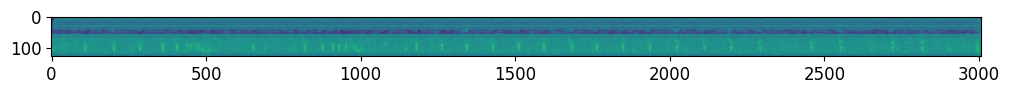

In [24]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_det'][0,0,:,:], norm=colors.LogNorm(vmin=1e-6, vmax=1e2))
plt.show()

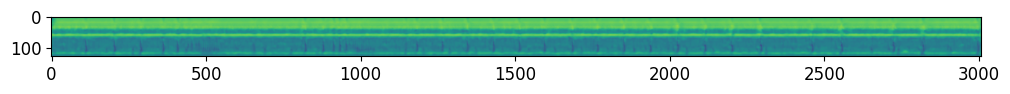

In [25]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_size'][0,0,:,:], norm=colors.LogNorm(vmin=1, vmax=1e2))
plt.show()

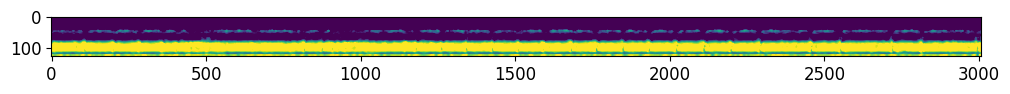

In [26]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['pred_class'][0,0,:,:], norm=colors.LogNorm(vmin=1e-8, vmax=1e-4))
plt.show()

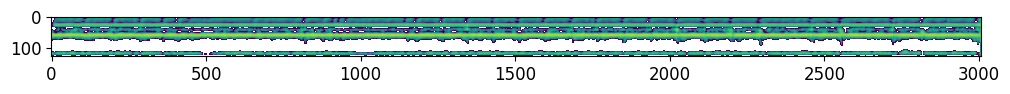

In [27]:
plt.figure(figsize=(12, 12))
plt.rcParams.update({'font.size':12})
plt.imshow(outputs['features'][0,0,:,:], norm=colors.LogNorm(vmin=1e-2, vmax=1e1))
plt.show()

In [28]:
# run non-max suppression
pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
pred_nms = pred_nms[0]
pred_nms['start_times'] += chunk_time
pred_nms['end_times'] += chunk_time
pred_nms

{'det_probs': array([0.49837214, 0.49140632, 0.57176876, 0.37221485, 0.3400548 ,
        0.3672308 , 0.33690423, 0.368025  , 0.3984032 , 0.37430823,
        0.44166994, 0.4080363 , 0.27016202, 0.45014304, 0.47399276,
        0.40166986, 0.413277  , 0.39044127, 0.41429085, 0.4107105 ,
        0.48117435, 0.42179623, 0.47986013, 0.5592908 , 0.5422772 ,
        0.53574926, 0.48713854, 0.51614004, 0.5221084 , 0.46824625,
        0.52667874, 0.24312186], dtype=float32),
 'x_pos': array([ 111.,  203.,  289.,  361.,  361.,  408.,  408.,  441.,  820.,
         879.,  913.,  933.,  954., 1182., 1264., 1345., 1429., 1513.,
        1594., 1684., 1766., 1850., 1937., 2024., 2113., 2200., 2293.,
        2459., 2554., 2722., 2818., 2997.], dtype=float32),
 'y_pos': array([101., 102., 103., 102.,  92.,  92., 102.,  92.,  96.,  99.,  92.,
         93.,  93.,  93.,  92.,  94.,  97.,  92.,  94.,  97.,  99.,  97.,
        100.,  99., 101., 100., 101., 100., 101., 100., 100., 109.],
       dtype=float32),

In [29]:
# if we have a background class
if pred_nms['class_probs'].shape[0] > len(params['class_names']):
    pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]
pred_nms

{'det_probs': array([0.49837214, 0.49140632, 0.57176876, 0.37221485, 0.3400548 ,
        0.3672308 , 0.33690423, 0.368025  , 0.3984032 , 0.37430823,
        0.44166994, 0.4080363 , 0.27016202, 0.45014304, 0.47399276,
        0.40166986, 0.413277  , 0.39044127, 0.41429085, 0.4107105 ,
        0.48117435, 0.42179623, 0.47986013, 0.5592908 , 0.5422772 ,
        0.53574926, 0.48713854, 0.51614004, 0.5221084 , 0.46824625,
        0.52667874, 0.24312186], dtype=float32),
 'x_pos': array([ 111.,  203.,  289.,  361.,  361.,  408.,  408.,  441.,  820.,
         879.,  913.,  933.,  954., 1182., 1264., 1345., 1429., 1513.,
        1594., 1684., 1766., 1850., 1937., 2024., 2113., 2200., 2293.,
        2459., 2554., 2722., 2818., 2997.], dtype=float32),
 'y_pos': array([101., 102., 103., 102.,  92.,  92., 102.,  92.,  96.,  99.,  92.,
         93.,  93.,  93.,  92.,  94.,  97.,  92.,  94.,  97.,  99.,  97.,
        100.,  99., 101., 100., 101., 100., 101., 100., 100., 109.],
       dtype=float32),

In [30]:
predictions.append(pred_nms)

# extract features - if there are any calls detected
if (pred_nms['det_probs'].shape[0] > 0):
    if args['spec_features']:
        spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

    if args['cnn_features']:
        cnn_feats.append(features[0])

    if args['spec_slices']:
        spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

In [31]:
predictions

[{'det_probs': array([0.49837214, 0.49140632, 0.57176876, 0.37221485, 0.3400548 ,
         0.3672308 , 0.33690423, 0.368025  , 0.3984032 , 0.37430823,
         0.44166994, 0.4080363 , 0.27016202, 0.45014304, 0.47399276,
         0.40166986, 0.413277  , 0.39044127, 0.41429085, 0.4107105 ,
         0.48117435, 0.42179623, 0.47986013, 0.5592908 , 0.5422772 ,
         0.53574926, 0.48713854, 0.51614004, 0.5221084 , 0.46824625,
         0.52667874, 0.24312186], dtype=float32),
  'x_pos': array([ 111.,  203.,  289.,  361.,  361.,  408.,  408.,  441.,  820.,
          879.,  913.,  933.,  954., 1182., 1264., 1345., 1429., 1513.,
         1594., 1684., 1766., 1850., 1937., 2024., 2113., 2200., 2293.,
         2459., 2554., 2722., 2818., 2997.], dtype=float32),
  'y_pos': array([101., 102., 103., 102.,  92.,  92., 102.,  92.,  96.,  99.,  92.,
          93.,  93.,  93.,  92.,  94.,  97.,  92.,  94.,  97.,  99.,  97.,
         100.,  99., 101., 100., 101., 100., 101., 100., 100., 109.],
        

In [37]:
out_df_resampled = run_detector_on_audio_data(model, args, params, resamp_audio_seg, resampling_rate)

71 call(s) detected above the threshold.
species name                  probablity present
Myotis daubentonii            0.375
Pipistrellus nathusii         0.364
Myotis brandtii               0.167
Myotis bechsteinii            0.041
Myotis mystacinus             0.014


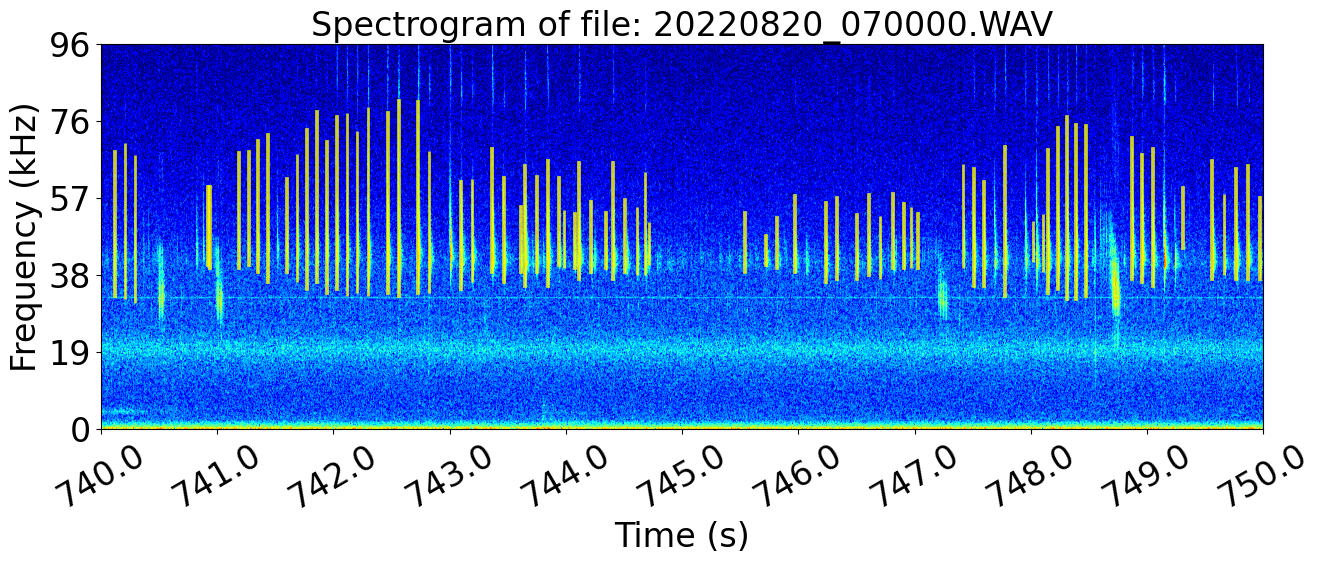

In [38]:
vmax = spec_features['vmax']
vmin = spec_features['vmin']
cmap = spec_features['cmap']
nfft = spec_features['NFFT']

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 24})
plt.title(spec_features['plot_title'], fontsize=24)
plt.specgram(original_audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

ax = plt.gca()
for i, row in out_df_original.iterrows():
    rect = patches.Rectangle(((row['start_time'])*(sampling_rate/2), row['low_freq']/(sampling_rate/2)), 
                    (row['end_time'] - row['start_time'])*(sampling_rate/2), (row['high_freq'] - row['low_freq'])/(sampling_rate/2), 
                    linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, sampling_rate/2000, 6).astype('int'))
plot_xtype = 'float'
if (file_duration > 60):
    plot_xtype = 'int'
plt.xticks(ticks=np.linspace(0, file_duration*(sampling_rate/2), 11), 
            labels=np.round(np.linspace(start, start+file_duration, 11, dtype=plot_xtype), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()

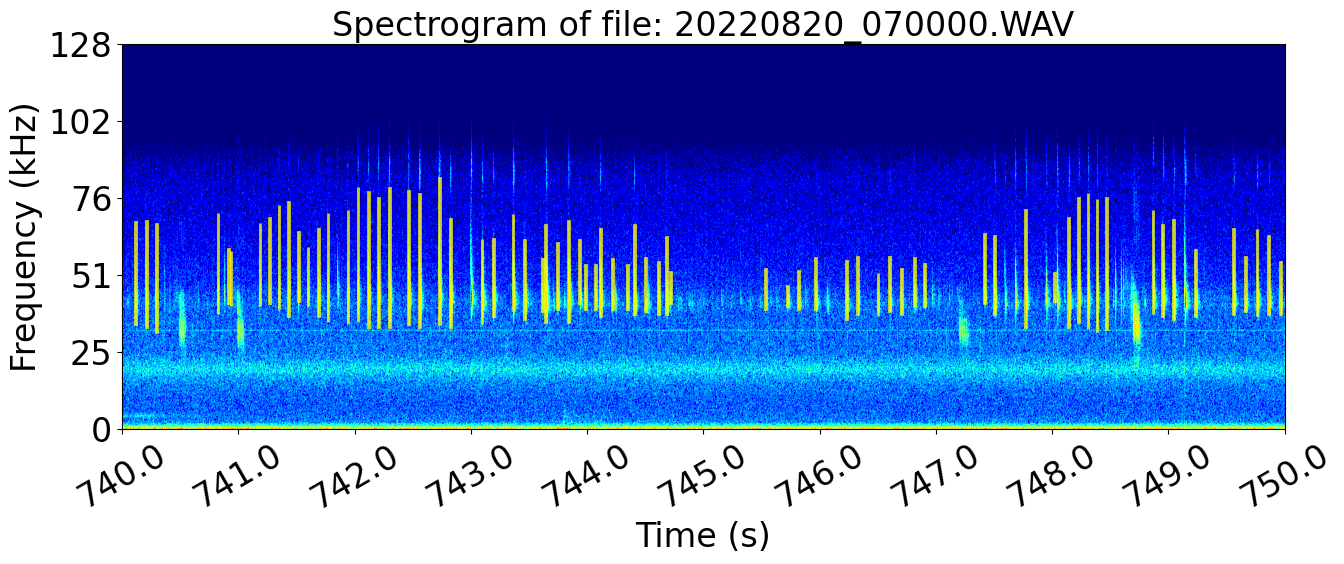

In [39]:
vmax = spec_features['vmax']
vmin = spec_features['vmin']
cmap = spec_features['cmap']
nfft = spec_features['NFFT']

plt.figure(figsize=(15, 5))
plt.rcParams.update({'font.size': 24})
plt.title(spec_features['plot_title'], fontsize=24)
plt.specgram(resamp_audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

ax = plt.gca()
for i, row in out_df_resampled.iterrows():
    rect = patches.Rectangle(((row['start_time'])*(resampling_rate/2), row['low_freq']/(resampling_rate/2)), 
                    (row['end_time'] - row['start_time'])*(resampling_rate/2), (row['high_freq'] - row['low_freq'])/(resampling_rate/2), 
                    linewidth=2, edgecolor='yellow', facecolor='none', alpha=0.8)
    ax.add_patch(rect)

plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, resampling_rate/2000, 6).astype('int'))
plot_xtype = 'float'
if (file_duration > 60):
    plot_xtype = 'int'
plt.xticks(ticks=np.linspace(0, file_duration*(resampling_rate/2), 11), 
            labels=np.round(np.linspace(start, start+file_duration, 11, dtype=plot_xtype), 2), rotation=30)
plt.ylabel("Frequency (kHz)")
plt.xlabel("Time (s)")
plt.show()